See developer site:

https://dev.socrata.com/foundry/data.cityofnewyork.us/jtpv-nuuc

NYC Open Data site on this survey:

https://data.cityofnewyork.us/Education/2019-20-School-Quality-Guide-Elementary-Middle-Sch/jtpv-nuuc

In [1]:
#!pip install sodapy

In [2]:
#pip install dash

In [3]:
#load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import dash
from dash import dcc
from dash import html
import nbformat
from sodapy import Socrata

# collaborative filtering libraries
from sklearn.decomposition import TruncatedSVD

# imputation libraries
from sklearn.impute import SimpleImputer, KNNImputer

# standardize variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# check versions
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'dash version: {dash.__version__}')
print(f'nbformat version: {nbformat.__version__}')

pandas version: 1.3.4
numpy version: 1.22.2
seaborn version: 0.11.1
dash version: 2.0.0
nbformat version: 5.1.3


In [5]:
# set seed to determine random number generator 
seed = 999

Extract the data using the Socrata Developer API

In [6]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

results = client.get("jtpv-nuuc", limit=2000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [7]:
df.shape

(1311, 146)

In [8]:
df.head()

,dbn,school_name,school_type,enrollment,survey_pp_ri,survey_pp_ct,survey_pp_se,survey_pp_es,survey_pp_sf,survey_pp_tr,...,n_prof_2plus_watn3_mthlevel1,val_prof_2plus_watn3_mthlevel1,n_prof_pct_watn3_elalevel2,val_prof_pct_watn3_elalevel2,n_prof_pct_watn3_elalevel34,val_prof_pct_watn3_elalevel34,n_prof_pct_watn3_mthlevel2,val_prof_pct_watn3_mthlevel2,n_prof_pct_watn3_mthlevel34,val_prof_pct_watn3_mthlevel34
0,01M015,P.S. 015 Roberto Clemente,Elementary,176,0.82,0.91,0.84,0.92,0.97,0.94,...,3,No Data,6,No Data,12,No Data,10,No Data,11,No Data
1,01M019,P.S. 019 Asher Levy,Elementary,220,0.87,0.91,0.94,0.9,0.96,0.91,...,3,No Data,7,No Data,18,0.778,4,No Data,21,0.667
2,01M020,P.S. 020 Anna Silver,Elementary,423,0.73,0.88,0.83,0.92,0.96,0.96,...,25,0.2,28,0.214,22,0.591,21,0.238,25,0.92
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,279,0.6,0.67,0.66,0.79,0.92,0.88,...,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
4,01M063,The STAR Academy - P.S.63,Elementary,203,0.72,0.87,0.83,0.94,0.97,0.94,...,2,No Data,6,No Data,14,No Data,8,No Data,10,No Data


In [9]:
df.describe()

,dbn,school_name,school_type,enrollment,survey_pp_ri,survey_pp_ct,survey_pp_se,survey_pp_es,survey_pp_sf,survey_pp_tr,...,n_prof_2plus_watn3_mthlevel1,val_prof_2plus_watn3_mthlevel1,n_prof_pct_watn3_elalevel2,val_prof_pct_watn3_elalevel2,n_prof_pct_watn3_elalevel34,val_prof_pct_watn3_elalevel34,n_prof_pct_watn3_mthlevel2,val_prof_pct_watn3_mthlevel2,n_prof_pct_watn3_mthlevel34,val_prof_pct_watn3_mthlevel34
count,1311,1311,1311,1311,1311,1311,1311,1311,1311,1311,...,1311,1311,1311,1311,1311,1311,1311,1311,1311,1311
unique,1311,1308,3,752,56,53,59,58,28,41,...,62,138,78,167,127,286,62,179,133,305
top,01M015,P.S. 360,Elementary,247,No Data,No Data,No Data,0.95,0.96,0.92,...,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
freq,1,2,693,7,164,163,164,68,197,90,...,687,1013,664,853,659,750,664,916,658,767


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Columns: 146 entries, dbn to val_prof_pct_watn3_mthlevel34
dtypes: object(146)
memory usage: 1.5+ MB


#### Helper functions

In [11]:
def catvardistribution(data,var,x,y,rot):
    print(data[var].value_counts(dropna=False))
    fig, ax = plt.subplots(figsize=(x,y)) # Set figure size
    sns.set(style="darkgrid")
    ax = sns.countplot(x=data[var], data=data, palette='Reds')
    plt.xticks(rotation=rot)
    plt.show()
    
def boxplot(data,var):
    print(data[var].describe())
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=data[var])
    plt.show()

### Feature engineering

Create district and borough variables

In [12]:
df['district'] = df['dbn'].str[0:2]
df['borough'] = df['dbn'].str[2:3]

In [13]:
# inspect new variables
print(f"Count of school districts: {len(np.unique(df['district']))}")
print(f"Count of school boroughs: {len(np.unique(df['borough']))}")

Count of school districts: 33
Count of school boroughs: 5


84    198
31     61
10     59
02     53
09     51
27     49
11     45
28     40
24     39
20     39
29     38
06     38
30     38
19     37
15     37
08     36
25     35
17     34
12     34
22     32
03     32
21     30
13     28
14     27
07     27
26     26
23     23
04     23
05     22
01     21
18     20
32     20
16     19
Name: district, dtype: int64


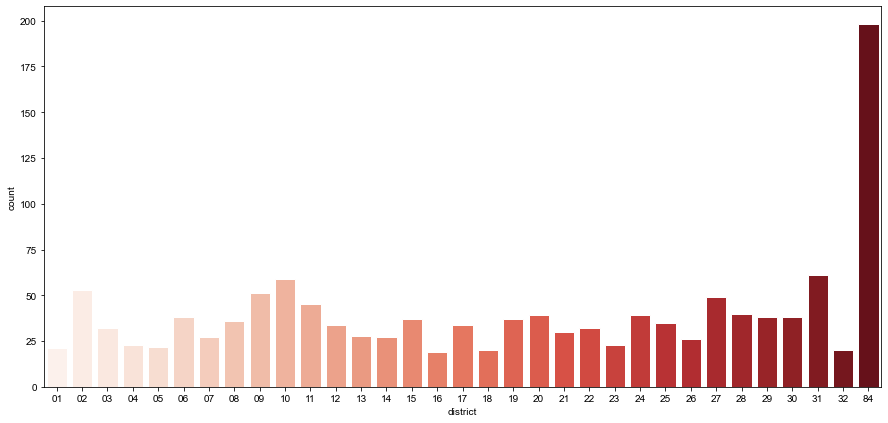

In [14]:
catvardistribution(data=df,var='district',x=15,y=7,rot=0)

K    421
X    309
Q    284
M    233
R     64
Name: borough, dtype: int64


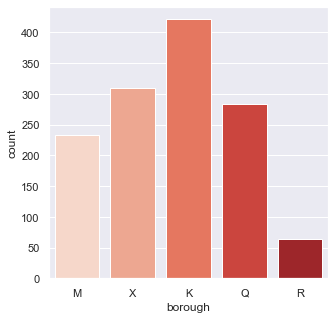

In [15]:
catvardistribution(data=df,var='borough',x=5,y=5,rot=0)

Group fields together - USE data dictionary as information source

In [16]:
# identification-related variables
ids = ['dbn','school_name','school_type','district','borough']

# surveys - percent positive
survey_proportions = ['survey_pp_ri', 'survey_pp_ct','survey_pp_se', 'survey_pp_es', 'survey_pp_sf', 'survey_pp_tr']

# survey response rate
survey_response_rate = ['rr_s', 'rr_t', 'rr_p']

# quality review - qualitative responses
quality_review = ['qr_1_1', 'qr_1_2', 'qr_2_2', 'qr_3_4', 'qr_4_2', 'qr_1_4', 'qr_1_3', 'qr_3_1', 'qr_4_1', 'qr_5_1']

# ratings on academic criteria
academic_ratings = ['rating_ela_grade_5_pct_rs', 'rating_mth_grade_5_pct_rs']

# student body and teacher demographic proportions
demographics = ['gender_female_pct', 'gender_male_pct','ethnicity_asian_pct','ethnicity_black_pct', 
                'ethnicity_hispanic_pct','ethnicity_amerindian_pct','ethnicity_pacific_pct', 'ethnicity_white_pct', 
                'teacher_ethnicity_asian_pct','teacher_ethnicity_black_pct', 'teacher_ethnicity_hispanic',
                'teacher_ethnicity_amerindian', 'teacher_ethnicity_pacific','teacher_ethnicity_white_pct',
                'near_pct_asian','near_pct_black', 'near_pct_hispanic', 'near_pct_amerindian',
                'near_pct_pacific', 'near_pct_white','ethnicity_asian_pct_dist',
                'ethnicity_black_pct_dist', 'ethnicity_hispanic_pct_dist',
                'ethnicity_amerindian_pct_1', 'ethnicity_pacific_pct_dist','ethnicity_white_pct_dist']

# socio-economic proportions
socioeconomics = ['ell', 'iep', 'cap_sc_pct','eni_pct_k8', 'temp_housing_pct','hra_elig_pct'] 

# least restrictive environment
restrictive_environment = ['n_lre_all', 'val_lre_all']

# principal or teacher experience
experience = ['principal_experience', 'teach_3_more_exp']

# student and teacher attendance 
attendance = ['val_attendance_k8_all', 'val_chronic_absent_ems_all','teacher_attendance','n_chronic_absent_ems_all',
             'n_attendance_k8_all', 'n_chronic_absent_ems_allea','n_chronic_absent_ems_alleb', 
              'val_chronic_absent_ems_alleb','n_chronic_absent_ems_alleh', 'val_chronic_absent_ems_alleh',
              'n_chronic_absent_ems_allei','n_chronic_absent_ems_allem', 'val_chronic_absent_ems_allem',
             'n_chronic_absent_ems_allep', 'val_chronic_absent_ems_allep','n_chronic_absent_ems_allew',
             'val_chronic_absent_ems_allew', 'n_chronic_absent_ems_allgf','val_chronic_absent_ems_allgf', 
              'n_chronic_absent_ems_allgm','val_chronic_absent_ems_allgm','val_chronic_absent_ems_allea',
             'val_chronic_absent_ems_allei']

# credits towards ninth grade (high school)
highschoolcredits = ['n_hs_9gr_credits_all', 'val_hs_9gr_credits_all',
                     'n_pct_accelerated_all', 'val_pct_accelerated_all']

# course pass rate across subjects
coursepassrate = ['n_pct_core_ela_all', 'val_pct_core_ela_all', 'n_pct_core_mth_all',
                  'val_pct_core_mth_all', 'n_pct_core_sci_all', 'val_pct_core_sci_all',
                  'n_pct_core_soc_all', 'val_pct_core_soc_all', 'n_ele_core_all','val_ele_core_all',
                 'n_pct_accel_p_lote_all','val_pct_accel_p_lote_all']

# interactions
interactions = ['n_interaction_k8_all','val_interaction_k8_all']

# eighth grade metrics
eighth_grade_metrics = ['n_pct_accel_lote_all',
       'val_pct_accel_lote_all', 'n_pct_accel_mth_all', 'n_pct_accel_p_all',
       'val_pct_accel_p_all','n_pct_accel_p_mth_all', 'n_pct_accel_p_sci_all',
       'val_pct_accel_p_sci_all', 'n_pct_accel_sci_all','val_pct_accel_sci_all', 'n_pct_accel_try_all', 
       'val_pct_accel_try_all','n_pct_accel_try_lote_all', 'val_pct_accel_try_lote_all',
       'n_pct_accel_try_mth_all','n_pct_accel_try_sci_all', 'val_pct_accel_try_sci_all']

# fifth grade metrics
fifth_grade_metrics = ['n_prof_2plus_watn5_elalevel1', 'val_prof_2plus_watn5_elalevel1',
                       'n_prof_2plus_watn5_mthlevel1', 'val_prof_2plus_watn5_mthlevel1',
                       'n_prof_pct_watn5_elalevel2', 'val_prof_pct_watn5_elalevel2',
                       'n_prof_pct_watn5_elalevel34', 'val_prof_pct_watn5_elalevel34',
                       'n_prof_pct_watn5_mthlevel2', 'val_prof_pct_watn5_mthlevel2',
                       'n_prof_pct_watn5_mthlevel34', 'val_prof_pct_watn5_mthlevel34']

# third grade metrics
third_grade_metrics = ['n_prof_pct_watn3_elalevel34', 'val_prof_pct_watn3_elalevel34',
                   'n_prof_pct_watn3_mthlevel2', 'val_prof_pct_watn3_mthlevel2',
                   'n_prof_pct_watn3_mthlevel34', 'val_prof_pct_watn3_mthlevel34',
                      'n_prof_2plus_watn3_elalevel1','val_prof_2plus_watn3_elalevel1',
                       'n_prof_2plus_watn3_mthlevel1','val_prof_2plus_watn3_mthlevel1',
                       'n_prof_pct_watn3_elalevel2','val_prof_pct_watn3_elalevel2']

# other indicators
other = ['enrollment','dates_of_review','median_distance','principal']

In [17]:
feature_dict = {'ids':ids, 'survey_proportions':survey_proportions, 
                'survey_response_rate':survey_response_rate,'quality_review':quality_review,
                'academic_ratings':academic_ratings, 'demographics':demographics,
               'socioeconomics':socioeconomics, 'restrictive_environment': restrictive_environment,
                'experience': experience, 'attendance': attendance, 'highschoolcredits':highschoolcredits,
                'coursepassrate': coursepassrate, 'interactions': interactions,
                'eighth_grade_metrics':eighth_grade_metrics, 'fifth_grade_metrics':fifth_grade_metrics,
               'third_grade_metrics':third_grade_metrics,
               'other':other}

In [18]:
def createdummies_fewvalues(variable, df):
    ''' Create dummies from variables with few values or low cardinality '''
    
    #Create dummy variables from the report status variable
    dummies = pd.get_dummies(df[variable])
    
    # include in dummies in dataset
    for col in dummies:
        df[f"{variable}_{col}"] = dummies[col]

In [19]:
def clean_names(df, column):
    ''' clean columns with strings and format mismatches'''
    df[column] = df[column].str.replace(r'N/A', '%') # remove spaces
    df[column] = df[column].str.rstrip('%')
    df[column] = df[column].replace(r'^\s*$', np.nan, regex=True)
    df[column] = df[column].astype('float')/100


In [20]:
for var in feature_dict['ids'][2:]:
    createdummies_fewvalues(variable=var, df=df)
    
for var in feature_dict['other'][:1]:
    df[var] = pd.to_numeric(df[var], errors='coerce')

# type cast variables to float
for var in feature_dict['survey_proportions']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

for var in feature_dict['survey_response_rate']:
    clean_names(df=df, column=var)

for var in feature_dict['quality_review']:
    createdummies_fewvalues(variable=var, df=df) 

for var in feature_dict['academic_ratings']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

for var in feature_dict['demographics']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['socioeconomics']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

for var in feature_dict['restrictive_environment']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['experience']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['attendance']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['highschoolcredits']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['coursepassrate']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['interactions']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['eighth_grade_metrics']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    
for var in feature_dict['fifth_grade_metrics']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

for var in feature_dict['third_grade_metrics']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    

In [21]:
# clean column names
df.columns = df.columns.str.replace('\s+', '_').str.lower() #lower case and remove spaces
df.columns = df.columns.str.replace('[(,),#,@,&]','')

In [22]:
# remove variables for analysis
X_remove = feature_dict['quality_review'] + feature_dict['ids'][2:] + feature_dict['other'][1:]
results_df = df.drop(list(X_remove), axis=1)

In [23]:
# set the index
df = df.set_index(results_df['dbn'])
results_df = results_df.set_index(results_df['dbn'])

In [24]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1311 entries, 01M015 to 84X730
Columns: 215 entries, dbn to qr_5_1_well_developed
dtypes: float64(129), int64(1), object(2), uint8(83)
memory usage: 1.4+ MB


In [25]:
results_df.select_dtypes(include=['object']).columns.to_list()

['dbn', 'school_name']

### Basic Exploratory Analysis

In [26]:
results_df.head(10)

,dbn,school_name,enrollment,survey_pp_ri,survey_pp_ct,survey_pp_se,survey_pp_es,survey_pp_sf,survey_pp_tr,rating_ela_grade_5_pct_rs,...,qr_3_1_well_developed,qr_4_1_developing,qr_4_1_no_data,qr_4_1_proficient,qr_4_1_well_developed,qr_5_1_developing,qr_5_1_no_data,qr_5_1_proficient,qr_5_1_under_developed,qr_5_1_well_developed
dbn,,,,,,,,,,,,,,,,,,,,,
01M015,01M015,P.S. 015 Roberto Clemente,176,0.82,0.91,0.84,0.92,0.97,0.94,NaN,...,0,0,0,0,1,0,0,1,0,0
01M019,01M019,P.S. 019 Asher Levy,220,0.87,0.91,0.94,0.90,0.96,0.91,NaN,...,1,0,0,0,1,0,0,0,0,1
01M020,01M020,P.S. 020 Anna Silver,423,0.73,0.88,0.83,0.92,0.96,0.96,NaN,...,0,0,0,1,0,1,0,0,0,0
01M034,01M034,P.S. 034 Franklin D. Roosevelt,279,0.60,0.67,0.66,0.79,0.92,0.88,NaN,...,0,0,0,1,0,1,0,0,0,0
01M063,01M063,The STAR Academy - P.S.63,203,0.72,0.87,0.83,0.94,0.97,0.94,NaN,...,0,0,0,0,1,0,0,1,0,0
01M064,01M064,P.S. 064 Robert Simon,202,0.90,0.97,0.90,0.97,0.98,0.97,NaN,...,0,0,0,0,1,0,0,1,0,0
01M110,01M110,P.S. 110 Florence Nightingale,361,0.61,0.79,0.65,0.83,0.95,0.87,NaN,...,0,0,0,1,0,1,0,0,0,0
01M134,01M134,P.S. 134 Henrietta Szold,235,0.63,0.76,0.69,0.84,0.95,0.90,NaN,...,0,0,0,1,0,0,0,1,0,0
01M140,01M140,P.S. 140 Nathan Straus,364,0.75,0.85,0.67,0.89,0.90,0.87,NaN,...,0,0,0,1,0,0,0,0,0,1


Inspect particular schools of interest

In [27]:
select_dbn = ['30Q398','30Q069','30Q212','30Q152','30Q222','30Q228','26Q159','28Q101']
select_df = results_df[results_df['dbn'].isin(select_dbn)]
select_df

,dbn,school_name,enrollment,survey_pp_ri,survey_pp_ct,survey_pp_se,survey_pp_es,survey_pp_sf,survey_pp_tr,rating_ela_grade_5_pct_rs,...,qr_3_1_well_developed,qr_4_1_developing,qr_4_1_no_data,qr_4_1_proficient,qr_4_1_well_developed,qr_5_1_developing,qr_5_1_no_data,qr_5_1_proficient,qr_5_1_under_developed,qr_5_1_well_developed
dbn,,,,,,,,,,,,,,,,,,,,,
26Q159,26Q159,P.S. 159,616,0.84,0.94,0.93,0.94,0.95,0.92,NaN,...,1,0,0,0,1,0,0,0,0,1
28Q101,28Q101,P.S. 101 School in the Gardens,662,0.81,0.84,0.88,0.87,0.97,0.88,NaN,...,1,0,0,0,1,0,0,0,0,1
30Q069,30Q069,P.S. 069 Jackson Heights,909,0.83,0.94,0.89,0.91,0.96,0.96,NaN,...,0,0,0,1,0,0,0,1,0,0
30Q152,30Q152,P.S. 152 Gwendoline N. Alleyne School,869,0.77,0.83,0.86,0.84,0.95,0.90,NaN,...,0,0,0,0,1,0,0,1,0,0
30Q212,30Q212,P.S. 212,721,0.76,0.94,0.84,0.86,0.96,0.92,NaN,...,0,0,0,1,0,0,0,1,0,0


In [28]:
district30elementary = results_df[(results_df['district_30']==1) & (results_df['school_type_elementary']==1)]

QR_1_1: Quality Review - How interesting and challenging is the curriculum?

In [29]:
### QR_1_1: Quality Review - How interesting and challenging is the curriculum?
district30elementary[['school_name','qr_1_1_proficient', 'qr_1_1_well_developed', 'qr_1_1_no_data','qr_1_1_developing']]

,school_name,qr_1_1_proficient,qr_1_1_well_developed,qr_1_1_no_data,qr_1_1_developing
dbn,,,,,
30Q002,P.S. 002 Alfred Zimberg,0,1,0,0
30Q011,P.S. 011 Kathryn Phelan,1,0,0,0
30Q017,P.S. 017 Henry David Thoreau,1,0,0,0
30Q069,P.S. 069 Jackson Heights,1,0,0,0
30Q070,P.S. 070,0,1,0,0
30Q076,P.S. 076 William Hallet,0,0,0,1
30Q084,P.S. 084 Steinway,1,0,0,0
30Q085,P.S. 085 Judge Charles Vallone,1,0,0,0
30Q092,P.S. 092 Harry T. Stewart Sr.,1,0,0,0


Proficient        625
Well Developed    389
No Data           201
Developing         96
Name: qr_1_1, dtype: int64


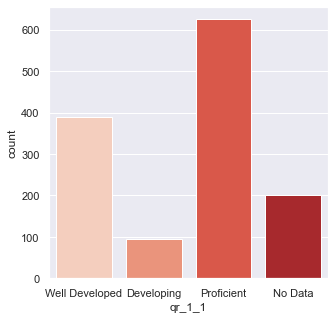

In [30]:
### QR_1_1: Quality Review - How interesting and challenging is the curriculum?
# All data
catvardistribution(data=df, var="qr_1_1",
                   x=5, y=5, rot=0)

Proficient        28
Well Developed     9
Developing         1
Name: qr_1_1, dtype: int64


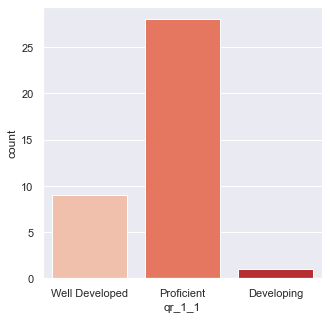

In [31]:
# District 30 schools only
catvardistribution(data=df[df['district']=='30'], var="qr_1_1",
                   x=5, y=5, rot=0)

QR_1_2: Quality Review - How effective is the teaching and learning?

Proficient        697
Developing        234
No Data           201
Well Developed    179
Name: qr_1_2, dtype: int64


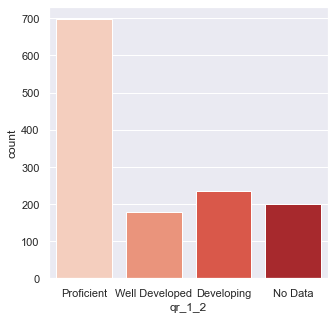

In [32]:
#### QR_1_2: Quality Review - How effective is the teaching and learning?
# All data
catvardistribution(data=df, var="qr_1_2",
                   x=5, y=5, rot=0)

Proficient        26
Well Developed     9
Developing         3
Name: qr_1_2, dtype: int64


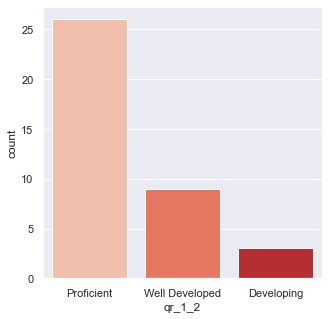

In [33]:
# District 30 schools only
catvardistribution(data=df[df['district']=='30'], var="qr_1_2",
                   x=5, y=5, rot=0)

In [309]:
district30elementary[['school_name','qr_1_2_proficient', 'qr_1_2_well_developed', 'qr_1_2_no_data','qr_1_2_developing']]

,school_name,qr_1_2_proficient,qr_1_2_well_developed,qr_1_2_no_data,qr_1_2_developing
dbn,,,,,
30Q002,P.S. 002 Alfred Zimberg,1,0,0,0
30Q011,P.S. 011 Kathryn Phelan,1,0,0,0
30Q017,P.S. 017 Henry David Thoreau,1,0,0,0
30Q069,P.S. 069 Jackson Heights,1,0,0,0
30Q070,P.S. 070,0,1,0,0
30Q076,P.S. 076 William Hallet,0,0,0,1
30Q084,P.S. 084 Steinway,0,1,0,0
30Q085,P.S. 085 Judge Charles Vallone,1,0,0,0
30Q092,P.S. 092 Harry T. Stewart Sr.,0,0,0,1


In [35]:
# correlation matrix for survey scores

def correlationMatrix(dataframe):
    corr = dataframe.iloc[:,1100:].corr()
    # create a triangular matrix
#     mask = np.triu(np.ones_like(dataframe.iloc[:,4:].corr(), dtype=np.bool))
    
    # plot the heatmap
    plt.figure(figsize=(50,20))
    heatmap = sns.heatmap(corr,
                         xticklabels=corr.columns,
                         yticklabels=corr.columns,
#                          mask=mask,
                         vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Correlation Heatmap of Survey Scores', fontdict={'fontsize':12}, pad=20);

# correlationMatrix(dataframe=district30elementary)

### Typical data analysis

#### Academic progression metrics comparison

Plot: Percentage of Students at Level 3 or 4 in 5th Grade (Out of Students at Level 3 or 4 in 3rd Grade) vs. Percentage of Students at Level 3 or 4 in 5th Grade (Out of Students at Level 2 in 3rd Grade), in `English Language Arts` 

In [328]:
fig = px.scatter(district30elementary, x="val_prof_pct_watn3_elalevel2", y="val_prof_pct_watn3_elalevel34", size='enrollment',
             color="school_name", hover_name="school_name")
fig.show()

Percentage of Students at Level 3 or 4 in 5th Grade (Out of Students at Level 3 or 4 in 3rd Grade) vs. Percentage of Students at Level 3 or 4 in 5th Grade (Out of Students at Level 2 in 3rd Grade), in `Math` 

In [327]:
fig = px.scatter(district30elementary, x="val_prof_pct_watn3_mthlevel2", y="val_prof_pct_watn3_mthlevel34", size='enrollment',
             color="school_name", hover_name="school_name")
fig.show()

Trust (Percent Positive) vs. Effective School Leadership (Percent Positive) 

In [326]:
fig = px.scatter(district30elementary, x="survey_pp_tr", y="survey_pp_es", size='enrollment',
             color="school_name", hover_name="school_name")

fig.show()
# fig.update_traces(marker_size=10)

In [38]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1311 entries, 01M015 to 84X730
Columns: 215 entries, dbn to qr_5_1_well_developed
dtypes: float64(129), int64(1), object(2), uint8(83)
memory usage: 1.4+ MB


### Model-based Collaborative Filtering

Enter school of interest 

In [318]:
# For example, top 5 schools in the city by proportion of 5th Grade students at Level 3 or 4 
# (Out of Students at Level 3 or 4 in 3rd Grade) in English Language Arts

df.sort_values(by="val_prof_pct_watn3_elalevel34", ascending=False).head()[['school_name','enrollment','borough',
                                                                                    'val_prof_pct_watn3_elalevel34']]

,school_name,enrollment,borough,val_prof_pct_watn3_elalevel34
dbn,,,,
02M077,P.S. 77 Lower Lab School,362,M,0.966
02M183,P.S. 183 Robert L. Stevenson,564,M,0.963
15K039,P.S. 039 Henry Bristow,417,K,0.957
02M059,P.S. 059 Beekman Hill International,619,M,0.946
02M042,P.S. 042 Benjamin Altman,514,M,0.942


In [322]:
# For example, top 5 schools in the city by proportion of 5th Grade students at Level 3 or 4 
# (Out of Students at Level 3 or 4 in 3rd Grade) in English Language Arts

df.sort_values(by="val_prof_pct_watn3_mthlevel34", ascending=False).head(6)[['school_name','enrollment','borough',
                                                                                    'val_prof_pct_watn3_mthlevel34']]

,school_name,enrollment,borough,val_prof_pct_watn3_mthlevel34
dbn,,,,
02M059,P.S. 059 Beekman Hill International,619,M,1.00
31R005,P.S. 005 Huguenot,315,R,1.00
02M267,"East Side Elementary School, PS 267",438,M,1.00
28Q196,P.S. 196 Grand Central Parkway,1045,Q,1.00
02M150,P.S. 150,172,M,1.00
84K781,Success Academy Charter School - Bergen Beach ...,710,K,0.99


In [320]:
school_of_interest = input("Please enter school of interest using District-Borough-School Number format \n")

Please enter school of interest using District-Borough-School Number format 
02M077


Enter district(s) or borough(s) to refine recommended schools.

See map of school districts: <https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj>

In [243]:
### borough of interest
borough_of_interest = school_of_interest[2].lower()
print(borough_of_interest)

m


In [244]:
### enter district of interest
district_of_interest = input("Please enter school districts of interest \n")

Please enter school districts of interest 
30


In [245]:
district_of_interest = list(district_of_interest)
district_of_interest = "".join(district_of_interest[0:2])
district_of_interest = [district_of_interest]
print(district_of_interest)

['30']


In [246]:
### enter district of interest
#district_of_interest = ["30","24"]
len(district_of_interest)

1

In [262]:
# modeldf = results_df.iloc[:,2:].copy()
if len(district_of_interest) == 1:
    modeldf = results_df[(results_df['dbn']==school_of_interest) | (results_df[f'district_{district_of_interest[0]}']==1)].iloc[:,2:].copy()
elif len(district_of_interest) == 2:
    modeldf = results_df[(results_df['dbn']==school_of_interest) | ((results_df[f'district_{district_of_interest[0]}']==1) | (results_df[f'district_{district_of_interest[1]}']==1))].iloc[:,2:].copy()
 
modeldf.T.head()

dbn,02M077,30Q002,30Q010,30Q011,30Q017,30Q069,30Q070,30Q076,30Q078,30Q084,...,30Q230,30Q234,30Q235,30Q280,30Q286,30Q291,30Q300,30Q329,30Q361,30Q580
enrollment,362.00,533.00,799.00,906.00,537.00,909.00,728.00,385.00,717.00,228.00,...,1192.00,420.00,85.00,575.00,262.00,420.00,544.00,448.00,366.00,121.00
survey_pp_ri,0.83,0.89,0.87,0.77,0.74,0.83,0.82,0.74,0.76,0.93,...,0.78,0.83,0.89,0.78,0.88,0.87,0.78,0.81,0.89,0.88
survey_pp_ct,0.74,0.93,0.95,0.87,0.86,0.94,0.93,0.85,0.86,0.95,...,0.89,0.86,0.98,0.84,0.80,0.94,0.79,0.93,0.96,0.82
survey_pp_se,0.79,0.92,0.96,0.84,0.77,0.89,0.91,0.74,0.65,0.93,...,0.73,0.84,0.92,0.85,0.76,0.80,0.80,0.87,0.95,0.81
survey_pp_es,0.68,0.89,0.95,0.84,0.87,0.91,0.93,0.87,0.82,0.93,...,0.90,0.87,0.98,0.87,0.65,0.94,0.74,0.97,0.92,0.78


Drop all columns with only zeros or only ones in them

In [263]:
modeldf = modeldf.loc[:, (modeldf != 0).any(axis=0)]
modeldf = modeldf.loc[:, (modeldf != 1).any(axis=0)]

In [264]:
# check the distribution of each variable
fig = px.box(pd.melt(modeldf.iloc[:,120:150]), x="variable", y="value", points="outliers")
fig.update_layout(height=600, width=900)

In [265]:
# must fill null values - WITH WHAT?
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
modeldf_Imp = pd.DataFrame(imputer.fit_transform(modeldf.T))

### apply standardized scalar
scaler = StandardScaler()
modeldf_Imp = pd.DataFrame(scaler.fit_transform(modeldf_Imp))
# modeldf_Imp.info()

In [266]:
modeldf_Imp.shape

(171, 39)

In [267]:
modeldf_Imp.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,5.834759,5.703238,4.077746,5.680004,5.672892,5.664785,5.687280,5.573974,5.659672,5.505915,...,4.002099,5.719263,3.599535,5.426131,3.962828,3.990159,5.532143,5.537825,5.713289,3.639306
1,-0.222424,-0.233336,-0.352781,-0.232650,-0.231130,-0.230262,-0.230484,-0.232256,-0.272508,-0.220905,...,-0.368411,-0.232347,-0.317055,-0.220608,-0.355800,-0.379587,-0.294080,-0.215483,-0.208055,-0.388573
2,-0.223933,-0.232890,-0.352337,-0.231997,-0.229809,-0.229548,-0.229589,-0.230594,-0.271680,-0.220401,...,-0.368008,-0.231921,-0.312865,-0.220018,-0.357123,-0.378857,-0.293973,-0.213939,-0.206920,-0.390585
3,-0.223095,-0.233001,-0.352281,-0.232193,-0.230800,-0.229872,-0.229752,-0.232256,-0.273419,-0.220905,...,-0.368595,-0.232205,-0.315658,-0.219919,-0.357785,-0.380317,-0.293865,-0.214711,-0.207082,-0.390921
4,-0.224939,-0.233336,-0.352337,-0.232193,-0.229699,-0.229742,-0.229589,-0.230292,-0.272011,-0.220905,...,-0.367971,-0.231779,-0.312865,-0.219723,-0.359604,-0.378857,-0.294509,-0.213424,-0.207569,-0.391927


### Perform an Singular Value Decomposition

$$ X = USV^{T} $$

where, $X$ is the original matrix of interest

$U$ is the left orthogonal matrix that holds important non-redundant about the schools

$S$ is the diagonal matrix that contains all information about the decomposition process 

$V$ is the right orthogonal matrix that holds important, non-redundant information about school attributes

#### Transpose the matrix

In [268]:
X = modeldf_Imp.T
X.shape

(39, 171)

In [269]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,5.834759,-0.222424,-0.223933,-0.223095,-0.224939,-0.220914,-0.225107,-0.229526,-0.229526,-0.228327,...,-0.236344,-0.219573,-0.236344,-0.236344,-0.236344,-0.219573,-0.236344,-0.236344,-0.236344,-0.219573
1,5.703238,-0.233336,-0.232890,-0.233001,-0.233336,-0.232778,-0.233224,-0.236739,-0.236739,-0.238111,...,-0.243265,-0.243265,-0.243265,-0.232109,-0.243265,-0.243265,-0.243265,-0.232109,-0.243265,-0.243265
2,4.077746,-0.352781,-0.352337,-0.352281,-0.352337,-0.352670,-0.352226,-0.343511,-0.342289,-0.355090,...,-0.352059,-0.357611,-0.357611,-0.357611,-0.352059,-0.357611,-0.357611,-0.357611,-0.352059,-0.357611
3,5.680004,-0.232650,-0.231997,-0.232193,-0.232193,-0.231409,-0.231605,-0.234048,-0.234048,-0.234525,...,-0.231148,-0.237680,-0.237680,-0.237680,-0.231148,-0.237680,-0.237680,-0.237680,-0.237680,-0.231148
4,5.672892,-0.231130,-0.229809,-0.230800,-0.229699,-0.228488,-0.228928,-0.234136,-0.234136,-0.233806,...,-0.228268,-0.239277,-0.228268,-0.239277,-0.239277,-0.239277,-0.239277,-0.239277,-0.228268,-0.239277


#### Decompose the matrix

In [270]:
# set number of latent features 
d =20
SVD = TruncatedSVD(n_components=d, random_state=17)
resultant_matrix = SVD.fit_transform(X)
resultant_matrix.shape

(39, 20)

#### Generate a correlation matrix

In [271]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape

(39, 39)

In [272]:
corr_mat

array([[1.        , 0.98075753, 0.64892558, ..., 0.90175998, 0.94785627,
        0.57928703],
       [0.98075753, 1.        , 0.67851648, ..., 0.95934639, 0.97265461,
        0.57471509],
       [0.64892558, 0.67851648, 1.        , ..., 0.68792616, 0.69105171,
        0.92419277],
       ...,
       [0.90175998, 0.95934639, 0.68792616, ..., 1.        , 0.97649298,
        0.54800346],
       [0.94785627, 0.97265461, 0.69105171, ..., 0.97649298, 1.        ,
        0.58333895],
       [0.57928703, 0.57471509, 0.92419277, ..., 0.54800346, 0.58333895,
        1.        ]])

In [273]:
school_names = modeldf.T.columns
school_list = list(school_names)

In [274]:
schoolofinterest = school_list.index(school_of_interest)
schoolofinterest

0

In [275]:
corr_schoolofinterest = corr_mat[school_list.index(school_of_interest)]
corr_schoolofinterest.shape

(39,)

In [348]:
corr_schoolofinterestlist = corr_schoolofinterest.tolist()
correlations_dict = {school_list[i]: corr_schoolofinterestlist[i] for i in range(len(school_list))}

# sort correlation dictionary by value
correlations_dict = {k: v for k, v in sorted(correlations_dict.items(), key=lambda item: item[1])}
correlation_df = pd.DataFrame(list(correlations_dict.items()),columns=['school','correlation'])

In [350]:
#### check out the highly correlated school
fig = px.bar(correlation_df, x="correlation", y="school", orientation='h', title='Correlations to school of interest')
fig.update_layout(height=600, width=900)
fig.show()

### Recommend highly correlated schools

What correlation level to your `school of interest` be acceptable?

In [351]:
correlation_level = input("Please enter the level of correlation to your school of interest that is acceptable \n")

Please enter the level of correlation to your school of interest that is acceptable 
98


In [355]:
# list(school_names[(corr_ps69q<1.0) & (corr_ps69q > 0.99)])
len(list(school_names[(corr_schoolofinterest<1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)]))

2

In which boroughs are these highly correlated schools?

Q    2
Name: borough, dtype: int64


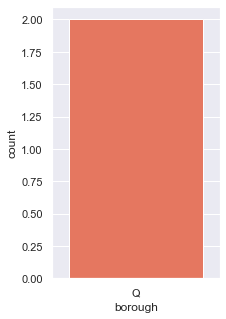

In [356]:
# catvardistribution(data=df.loc[list(school_names[(corr_schoolofinterest<1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])],
#                    var='borough',x=3,y=5,rot=0)

In which districts are these highly correlated schools?

30    2
Name: district, dtype: int64


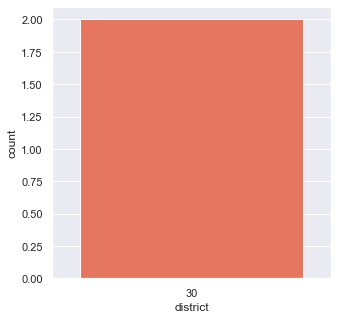

In [357]:
# catvardistribution(data=df.loc[list(school_names[(corr_schoolofinterest<1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])],
#                    var='district',x=5,y=5,rot=0)

What are the school types of the highly correlated schools?

In [359]:
# catvardistribution(data=df.loc[list(school_names[(corr_schoolofinterest<1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])],
#                    var='school_type',x=4,y=4,rot=0)

In [281]:
# correlationMatrix(dataframe=results_df.loc[list(school_names[(corr_ps212q<1.0) & (corr_ps212q > 0.99)])])

In [360]:
df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])][['school_name','borough','district','principal',
                                                                                           'enrollment','principal_experience','teach_3_more_exp',
                                                                                            'val_prof_pct_watn3_mthlevel34', 'val_prof_pct_watn3_elalevel34']]

,school_name,borough,district,principal,enrollment,principal_experience,teach_3_more_exp,val_prof_pct_watn3_mthlevel34,val_prof_pct_watn3_elalevel34
dbn,,,,,,,,,
02M077,P.S. 77 Lower Lab School,M,02,Sandra Miller,362,5.0,0.647,0.983,0.966
30Q002,P.S. 002 Alfred Zimberg,Q,30,Amy Goldman,533,5.0,0.973,0.896,0.766
30Q085,P.S. 085 Judge Charles Vallone,Q,30,ANN GORDON CHANG,590,17.1,0.675,0.851,0.735


Check how many feature values are null in the highly correlated set?

<AxesSubplot:ylabel='dbn'>

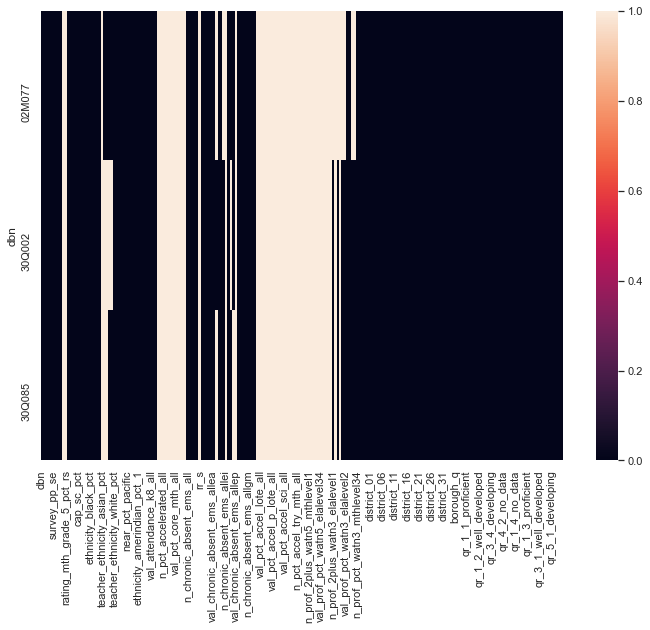

In [361]:
import seaborn as sns
sns.heatmap(results_df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])].isnull())

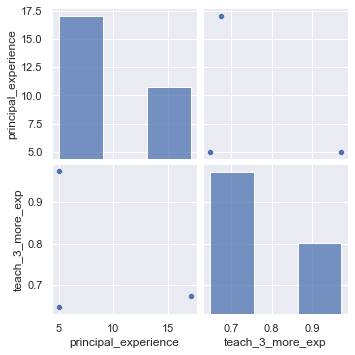

In [362]:
sns.pairplot(results_df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])][experience], )

In [369]:
results_df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])].iloc[:20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 02M077 to 30Q085
Columns: 215 entries, dbn to qr_5_1_well_developed
dtypes: float64(129), int64(1), object(2), uint8(83)
memory usage: 3.4+ KB


In [286]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > 0.999)])], 
#                         title="School Survey Data", explorative=True)

In [373]:
fig = px.scatter(results_df.loc[list(school_names[(corr_schoolofinterest<=1.0) & (corr_schoolofinterest > np.float(correlation_level)*.01)])], 
                 x="val_prof_pct_watn3_mthlevel34", y="val_prof_pct_watn3_elalevel34", size='enrollment',
                 color="school_name", hover_name="school_name")

fig.show()

### Recommend schools in similar cluster using unsupervised learning

### Principal Components Analysis (PCA)

PCA is a linear dimension reduction technique that seeks to maximize variance and preserves large pairwise distances. In other words, things that are different end up far apart. PCA was developed in 1933.

In [295]:
# libraries
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

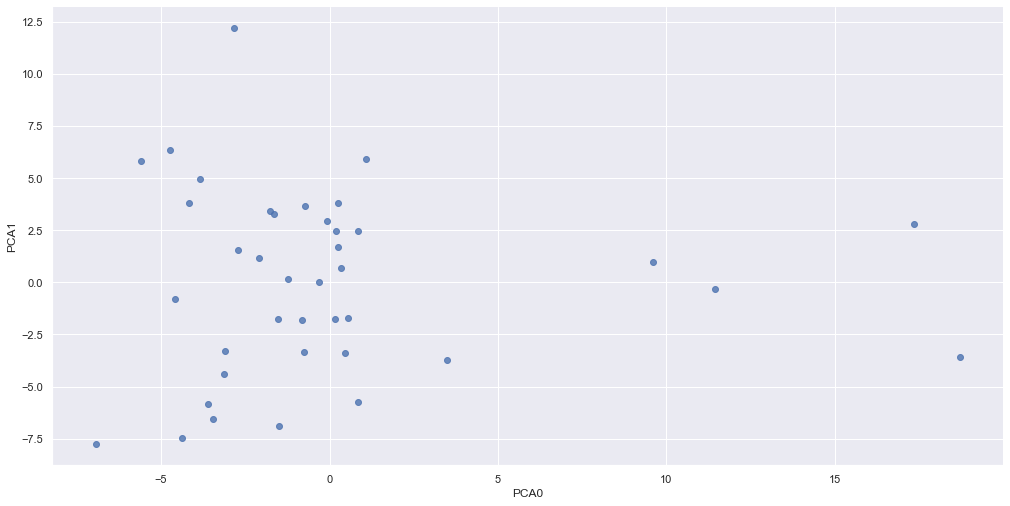

In [296]:
modeldf_Imp = pd.DataFrame(imputer.fit_transform(modeldf))

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(modeldf_Imp))

modeldf_Imp['dbn'] = modeldf.index # preserve index in model dataframe

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
pca_df = pd.concat([pd.DataFrame(data = x_pca, columns = ['PCA0', 'PCA1']), modeldf_Imp], axis = 1)
sns.lmplot(x="PCA0", y="PCA1", data=pca_df, fit_reg=False, height=7, aspect=2)

In [297]:
# PCA plot with plotly 
fig = px.scatter(pca_df, x="PCA0", y="PCA1", 
                 color="dbn", hover_name="dbn")

fig.update_traces(marker_size=10)

fig.show()

In [298]:
pca_df.head()

,PCA0,PCA1,0,1,2,3,4,5,6,7,...,160,161,162,163,164,165,166,167,168,dbn
0,-2.822655,12.214882,362.0,0.83,0.74,0.79,0.68,0.92,0.67,2.88,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,02M077
1,0.186086,2.465534,533.0,0.89,0.93,0.92,0.89,0.94,0.90,2.88,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,30Q002
2,3.478591,-3.700713,799.0,0.87,0.95,0.96,0.95,0.89,0.97,2.54,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,30Q010
3,0.343226,0.682537,906.0,0.77,0.87,0.84,0.84,0.96,0.93,2.88,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,30Q011
4,-3.143382,-4.395589,537.0,0.74,0.86,0.77,0.87,0.98,0.94,2.88,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30Q017


In [299]:
pca_df[pca_df['dbn']==school_of_interest ]

,PCA0,PCA1,0,1,2,3,4,5,6,7,...,160,161,162,163,164,165,166,167,168,dbn
0,-2.822655,12.214882,362.0,0.83,0.74,0.79,0.68,0.92,0.67,2.88,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,02M077


#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data, developed in 2008 by Laurens van der Maatens and Geoffrey Hinton.

t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance. 

In [300]:
from scipy.spatial.distance import pdist
#from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("mako")

In [301]:
# sci-kit learn implementation of t-SNE
tsne = TSNE(n_components = 2, 
           perplexity = 50,
           #early_exaggeration = 5,
           #learning_rate = 'auto',
           #n_iter = 500,
           #n_iter_without_progress = 250,
           metric = 'euclidean',
           method = 'exact',
           random_state = seed)
X_embedded = pd.DataFrame(tsne.fit_transform(modeldf_Imp.iloc[:,:-1]))
X_embedded['dbn'] = modeldf.index # preserve index in model dataframe

In [302]:
X_embedded.head()

,0,1,dbn
0,31.764725,45.926044,02M077
1,24.583681,3.840926,30Q002
2,-85.689445,7.075702,30Q010
3,29.917683,128.347931,30Q011
4,72.687721,107.379913,30Q017


In [303]:
X_embedded[X_embedded['dbn']==school_of_interest]

,0,1,dbn
0,31.764725,45.926044,02M077


In [304]:
# t-SNE plot with plotly 
fig = px.scatter(X_embedded, x=0, y=1, 
                 color="dbn", hover_name="dbn")

fig.update_traces(marker_size=10)

fig.show()